# Libraries and Imports

In [1]:
# import relevant libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# preprocessing modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk import pos_tag, word_tokenize
import regex as re

# lda
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

# machine learning libraries and modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, balanced_accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# others
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Read in Datasets

In [2]:
# read in lemmatized datasets

pubg_ml = pd.read_csv('datasets/pubgcleaned.csv')
cyberpunk_ml = pd.read_csv('datasets/cyberpunkcleaned.csv')
fallguys_ml = pd.read_csv('datasets/fallguyscleaned.csv')

In [3]:
# create dictionary of dataframes and names

dfs_ml = {"PlayerUnknown's Battlegrounds": pubg_ml, 
          "Cyberpunk 2077": cyberpunk_ml, 
          "Fall Guys": fallguys_ml
         }

# Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is an unsupervised machine learning algorithm that takes in a corpus of documents as input and returns a list of imaginary 'topics' as the output, where each of the topics represents a set of words. In essence, each document comprises a distribution of topics, and each topic comprises a distribution of representative words.

Ideally, by performing LDA on our set of reviews, we would be able to further distill some of the main gameplay aspects/themes that players favour, or tend to have grievances/complaints. This would allow the game developers to better grasp the positive points that should be replicated in future games, as well as identify negative aspects or weaknesses in the games that need to be quickly addressed to retain their current player base.

As such, we will attempt to segregate the topic modelling by positive/negative reviews for each game, as we expect different topics to emerge from these two classes of reviews. For each topic, as part of the LDAvis visualization, we will also use the suggested optimal value of $\lambda = 0.6$ to rank the terms in accordance to their topic relevance, and to try deciphering the main gist of each topic by examining the representative words.

## PUBG

### Positive

In [4]:
def build_bigrams_trigrams(sentiment, df):
    
    """
    Build bigrams and trigrams based on a particular sentiment from the lemmatized text of a dataset and returns
    the processed text.
    """
    
    df_lda_text = df[df['label'] == sentiment]['lemmed_text']
    df_lda_text_split = [text.split() for text in df_lda_text]
    
    # create phrases object to learn bigrams and trigrams. trigrams will also be made out of the bigrams
    # higher the min_count and threshold, fewer phrases
    bigram = gensim.models.Phrases(df_lda_text_split, min_count=5, threshold=100) # higher threshold, fewer phrases
    trigram = gensim.models.Phrases(bigram[df_lda_text_split], min_count=3, threshold=100)

    # process bigrams and trigrams
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # process text to generate bigrams and trigrams
    processed_text = [trigram_mod[bigram_mod[text]] for text in df_lda_text_split]
    
    # create dictionary
    id2word = corpora.Dictionary(processed_text)

    # create corpus: term document frequency
    corpus = [id2word.doc2bow(text) for text in processed_text]
    
    return processed_text, id2word, corpus

In [5]:
pubg_pos_processed_text, pubg_pos_id2word, pubg_pos_corpus = build_bigrams_trigrams(1, pubg_ml)

In [6]:
# build LDA model

pubg_pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=pubg_pos_corpus,
                                                     id2word=pubg_pos_id2word,
                                                     num_topics=3, 
                                                     random_state=42,
                                                     update_every=1,
                                                     chunksize=100,
                                                     passes=10,
                                                     alpha='auto',
                                                     iterations=100,
                                                     per_word_topics=True)

In [7]:
# define function to show each document, the dominant topic, topic contribution and text

def format_topics_sentences(ldamodel, corpus, texts):
    
    # initialize output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # get the dominant topic, topic perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Percentage_Contribution', 'Topic_Keywords']

    # add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)

In [8]:
# put together in a dataframe and show documents and their topics for the dataset

def display_dominant_topics(ldamodel, corpus, texts, number_of_rows=10):

    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

    # formatting
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Percentage_Contribution', 'Keywords', 'Text']
    display(df_dominant_topic.head(number_of_rows))

In [9]:
display_dominant_topics(pubg_pos_lda_model, pubg_pos_corpus, pubg_pos_processed_text, 15)

,Document_No,Dominant_Topic,Percentage_Contribution,Keywords,Text
0,0,0.0,0.7137,"game, play, get, well, like, fun, good, h1z1, ...","[great, game, always, fun, play, run, much, we..."
1,1,1.0,0.4887,"player, server, fix, update, weapon, not, map,...","[fun, way, test, reaction, eye, sight, strateg..."
2,2,0.0,0.5001,"game, play, get, well, like, fun, good, h1z1, ...","[only, battle, royale, thats, actual, gun, ski..."
3,3,0.0,0.7028,"game, play, get, well, like, fun, good, h1z1, ...","[chicken_dinner, more, like, broke, fight, pie..."
4,4,0.0,0.6975,"game, play, get, well, like, fun, good, h1z1, ...","[one, best, game, game, good, not, even, dead,..."
5,5,0.0,0.6263,"game, play, get, well, like, fun, good, h1z1, ...","[best, battle, royale, game, ever, yes, player..."
6,6,1.0,0.5035,"player, server, fix, update, weapon, not, map,...","[survival, element, pick, experiment, weapon, ..."
7,7,2.0,0.3847,"10, get, kill, 1, 3, 5, car, 2, die, 4","[night, hear, 'em, talk, coldest, story, ever,..."
8,8,0.0,0.8496,"game, play, get, well, like, fun, good, h1z1, ...","[i'm, only, make, review, positive, respect, g..."
9,9,0.0,0.6457,"game, play, get, well, like, fun, good, h1z1, ...","[gr8, pair, lvl, 500, people, lvl, 18, lvl30, ..."


In [10]:
# show the topics and representative documents for the dataset

def display_representative_docs(ldamodel, corpus, texts):
    
    # initialize dataframe
    sent_topics_sorteddf_mallet = pd.DataFrame()
    
    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)
    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Percentage_Contribution'], ascending=False).head(1)], 
                                                 axis=0)

    # reset index
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Percentage_Contribution', 'Keywords', 'Representative Text']

    # display
    display(sent_topics_sorteddf_mallet.head(10))

In [11]:
display_representative_docs(pubg_pos_lda_model, pubg_pos_corpus, pubg_pos_processed_text)

,Topic_Num,Topic_Percentage_Contribution,Keywords,Representative Text
0,0.0,0.9322,"game, play, get, well, like, fun, good, h1z1, ...","[didn't, want, review, till, full, realease, g..."
1,1.0,0.7746,"player, server, fix, update, weapon, not, map,...","[game, good, problem, region, due, high, numbe..."
2,2.0,0.8633,"10, get, kill, 1, 3, 5, car, 2, die, 4","[ingredient, 3, 4, cup_plain, breadcrumb, 3, 4..."


In [12]:
def compute_perp_coherence(ldamodel, corpus, dictionary, texts):

    # compute perplexity - measure of how good the model is (lower, the better)
    print(f'Perplexity: {ldamodel.log_perplexity(corpus):.4f}') 

    # compute coherence score (higher, the better)
    coherence_model_lda = CoherenceModel(model=ldamodel,
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         corpus=corpus, 
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Coherence Score: {coherence_lda:.4f}')

In [13]:
compute_perp_coherence(ldamodel=pubg_pos_lda_model, 
                       dictionary=pubg_pos_id2word,
                       corpus=pubg_pos_corpus, 
                       texts=pubg_pos_processed_text)

Perplexity: -7.2389
Coherence Score: 0.4079


In [14]:
# visualize the topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(pubg_pos_lda_model, pubg_pos_corpus, pubg_pos_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.223915  0.206442       1        1  54.731697
1     -0.108492 -0.260487       2        1  32.814592
2      0.332407  0.054045       3        1  12.453711, topic_info=       Term           Freq          Total Category  logprob  loglift
4      game  125727.000000  125727.000000  Default  30.0000  30.0000
377      10   15751.000000   15751.000000  Default  29.0000  29.0000
54      get   29637.000000   29637.000000  Default  28.0000  28.0000
8      play   24098.000000   24098.000000  Default  27.0000  27.0000
127    kill    8300.000000    8300.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
371   would    2355.956661   10948.903533   Topic3  -4.7545   0.5469
59    start    1845.919092    4999.175957   Topic3  -4.9984   1.0869
33      gun    2100.000792    8303.980354   Topic3  -4.8695   0.7084
215      go    1874.005781   10011.366657   Topic3  -4.9833   0.4075
505  around    1581.669060    4084.043822   Topic3  -5.1529   1.1345

[181 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
278       3  0.998434       0
234       3  0.999791       1
377       3  0.999950      10
1435      2  0.999794     100
1338      3  0.999513      11
...     ...       ...     ...
79        2  0.999893  weapon
13        1  0.999979    well
370       1  0.999853   worth
371       1  0.784827   would
371       3  0.215181   would

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

Each bubble in the Intertopic Distance Map represents a topic, with its size indicating the prevalence of the topic in the set of documents (reviews). The representative words in the topic are shown on the right hand side, with the blue bars indicating the overall term frequency, and the red bars indicating the estimated term frequency within the selected topic itself. Well-defined topics are typically scattered throughout the chart.

**Topic Interpretation**

- **1**: overall enjoyment of the game, comparison to other predecessor battle royale games (h1z1, arma), early access bugs
- **2**: suggestions for improvement (fix, update, developer, team, hope)
- **3**: spam tokens, description of gameplay (shoot, loot, plane, house)


In [15]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    
    """
    Compute c_v coherence for various number of topics up to the limit and returns the model_list and coherence values.
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # build lda model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=dictionary,
                                                        num_topics=num_topics, 
                                                        random_state=42,
                                                        update_every=1,
                                                        chunksize=100,
                                                        passes=10,
                                                        alpha='auto',
                                                        iterations=100,
                                                        per_word_topics=True)
          
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# define function to display the coherence values

def display_coherence_values(dictionary, corpus, texts, start=2, limit=8, step=1):
    
    """
    Display coherence values and plot graph of coherence values with number of topics.
    """

    # generates all the models and coherence values for the various number of topics specified
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                            corpus=corpus, 
                                                            texts=texts, 
                                                            limit=limit, 
                                                            start=start, 
                                                            step=step)

    for no_steps, coherence_value in enumerate(coherence_values):
        print(f'Coherence value for {start + no_steps} topics: {coherence_value:.4f}')
        
    # display graph
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("No. of topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

Coherence value for 2 topics: 0.3965
Coherence value for 3 topics: 0.4079
Coherence value for 4 topics: 0.3816
Coherence value for 5 topics: 0.3613
Coherence value for 6 topics: 0.3650
Coherence value for 7 topics: 0.3599


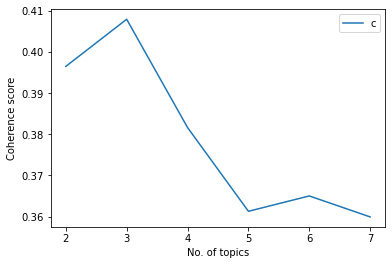

In [17]:
display_coherence_values(pubg_pos_id2word, pubg_pos_corpus, pubg_pos_processed_text, start=2, limit=8, step=1)

### Negative

In [18]:
pubg_neg_processed_text, pubg_neg_id2word, pubg_neg_corpus = build_bigrams_trigrams(0, pubg_ml)

In [19]:
# build LDA model

pubg_neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=pubg_neg_corpus,
                                                     id2word=pubg_neg_id2word,
                                                     num_topics=3, 
                                                     random_state=42,
                                                     update_every=1,
                                                     chunksize=100,
                                                     passes=10,
                                                     alpha='auto',
                                                     iterations=100,
                                                     per_word_topics=True)

In [20]:
display_dominant_topics(pubg_neg_lda_model, pubg_neg_corpus, pubg_neg_processed_text, 15)

,Document_No,Dominant_Topic,Percentage_Contribution,Keywords,Text
0,0,2.0,0.7470,"game, not, play, still, fix, make, server, mor...","[only, reason, bought, game, friend, blast, ga..."
1,1,2.0,0.5063,"game, not, play, still, fix, make, server, mor...","[computer, wont, even, open, game, know, isnt,..."
2,2,2.0,0.7083,"game, not, play, still, fix, make, server, mor...","[complete, trash, instead, fix, broken, trash,..."
3,3,2.0,0.8168,"game, not, play, still, fix, make, server, mor...","[back, day, game, use, favorite, battle_royal,..."
4,4,2.0,0.7101,"game, not, play, still, fix, make, server, mor...","[warzone_apex_legend, way, well, alternative, ..."
5,5,2.0,0.5063,"game, not, play, still, fix, make, server, mor...","[i'm, go, echo, most, review, say, launch, tim..."
6,6,0.0,0.6069,"get, like, game, time, run, kill, one, not, no...","[swear, ethereal, pantheon, humanity's, variou..."
7,7,2.0,0.6306,"game, not, play, still, fix, make, server, mor...","[game, performance, shit, cheater, 2, 3, match..."
8,8,2.0,0.5340,"game, not, play, still, fix, make, server, mor...","[people, think, buy, game, aware, follow, game..."
9,9,2.0,0.6903,"game, not, play, still, fix, make, server, mor...","[played, game, lot, first, come, great, game, ..."


In [21]:
display_representative_docs(pubg_neg_lda_model, pubg_neg_corpus, pubg_neg_processed_text)

,Topic_Num,Topic_Percentage_Contribution,Keywords,Representative Text
0,0.0,0.9507,"get, like, game, time, run, kill, one, not, no...","[round, 1, wait, jump, land, scavenge, run, ar..."
1,1.0,0.8724,"fps, low, ban, pc, setting, run, computer, hig...","[no, no, free_tibet_tiananmen_square, protest_..."
2,2.0,0.9224,"game, not, play, still, fix, make, server, mor...","[bug, bug, bug, bug, bug, bug, bug, bug, bug, ..."


In [22]:
compute_perp_coherence(ldamodel=pubg_neg_lda_model, 
                       dictionary=pubg_neg_id2word,
                       corpus=pubg_neg_corpus, 
                       texts=pubg_neg_processed_text)

Perplexity: -7.2453
Coherence Score: 0.4451


In [23]:
# visualize the topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(pubg_neg_lda_model, pubg_neg_corpus, pubg_neg_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.220320  0.202906       1        1  53.219217
0     -0.166368 -0.222700       2        1  43.155870
1      0.386688  0.019794       3        1   3.624913, topic_info=        Term           Freq          Total Category  logprob  loglift
11      game  172921.000000  172921.000000  Default  30.0000  30.0000
100      run   13960.000000   13960.000000  Default  29.0000  29.0000
267      fps    7257.000000    7257.000000  Default  28.0000  28.0000
144      get   39149.000000   39149.000000  Default  27.0000  27.0000
481      low    5346.000000    5346.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
392     high    1578.531984    4367.376990   Topic3  -4.2348   2.2997
789  graphic    1128.730083    3301.728580   Topic3  -4.5702   2.2440
100      run    2133.533167   13960.977111   Topic3  -3.9335   1.4389
466       40     490.380820    1089.420648   Topic3  -5.4038   2.5191
489      set     488.831487    1287.546464   Topic3  -5.4070   2.3489

[175 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
330       1  0.259385      1
330       2  0.740568      1
569       2  0.999959     10
158       1  0.000469      2
158       2  0.999422      2
...     ...       ...    ...
116       2  0.249561   well
300       2  0.999813    win
62        1  0.835605  would
62        2  0.164364  would
235       1  0.999848   year

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

**Topic Interpretation**

- **1**: generic negative sentiments about the game (shit, problem, bug)
- **2**: generic gameplay terms (gun, map, loot)
- **3**: hardware and technical related issues e.g. fps (stutter, freezing), graphics settings (medium, high, ultra), community issues (stream sniping, ban, account)

Coherence value for 2 topics: 0.3904
Coherence value for 3 topics: 0.4451
Coherence value for 4 topics: 0.3515
Coherence value for 5 topics: 0.3964
Coherence value for 6 topics: 0.3506
Coherence value for 7 topics: 0.3386


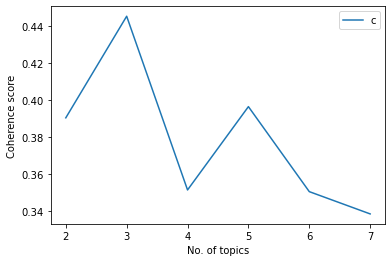

In [24]:
display_coherence_values(pubg_neg_id2word, pubg_neg_corpus, pubg_neg_processed_text, start=2, limit=8, step=1)

## Cyberpunk

### Positive

In [25]:
cyberpunk_pos_processed_text, cyberpunk_pos_id2word, cyberpunk_pos_corpus = build_bigrams_trigrams(1, cyberpunk_ml)

In [26]:
# build LDA model

cyberpunk_pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=cyberpunk_pos_corpus,
                                                          id2word=cyberpunk_pos_id2word,
                                                          num_topics=3, 
                                                          random_state=42,
                                                          update_every=1,
                                                          chunksize=100,
                                                          passes=10,
                                                          alpha='auto',
                                                          iterations=100,
                                                          per_word_topics=True)

In [27]:
display_dominant_topics(cyberpunk_pos_lda_model, cyberpunk_pos_corpus, cyberpunk_pos_processed_text, 15)

,Document_No,Dominant_Topic,Percentage_Contribution,Keywords,Text
0,0,0.0,0.9320,"game, bug, play, not, get, far, story, good, g...","[despite, people, say, game's, fuck, amaze, lo..."
1,1,0.0,0.9185,"game, bug, play, not, get, far, story, good, g...","[game, isn't, without, bug, relatively, easy, ..."
2,2,0.0,0.5418,"game, bug, play, not, get, far, story, good, g...","[atmospheric, great, game, play, voice_act, gr..."
3,3,1.0,0.5614,"feel, character, like, drive, not, city, go, m...","[really, unsure, drawn, game, look, non, techn..."
4,4,0.0,0.8718,"game, bug, play, not, get, far, story, good, g...","[really, good, game, perfect, storyline, great..."
5,5,0.0,0.8726,"game, bug, play, not, get, far, story, good, g...","[game, amaze, stop, whine, like, bunch, entitl..."
6,6,0.0,0.7505,"game, bug, play, not, get, far, story, good, g...","[everyone, know, bug, easy, deal, sometimes, s..."
7,7,0.0,0.6122,"game, bug, play, not, get, far, story, good, g...","[ok, only, 3, hour, come, ps4, pro, port, game..."
8,8,0.0,0.8714,"game, bug, play, not, get, far, story, good, g...","[good, game, big, letdown, many, way, still, r..."
9,9,0.0,0.5283,"game, bug, play, not, get, far, story, good, g...","[good, game, compelling, gameplay, fantastic, ..."


In [28]:
display_representative_docs(cyberpunk_pos_lda_model, cyberpunk_pos_corpus, cyberpunk_pos_processed_text)

,Topic_Num,Topic_Percentage_Contribution,Keywords,Representative Text
0,0.0,0.9863,"game, bug, play, not, get, far, story, good, g...","[fun, game, first, start, play, didn't, go, ex..."
1,1.0,0.8955,"feel, character, like, drive, not, city, go, m...","[game, great, grievance, many, key, key, map, ..."
2,2.0,0.8814,"run, fps, setting, ultra, high, low, 60, dl, p...","[nrfr, jehrhrhrhhehehehe, fuff, fffufn, fdhaga..."


In [29]:
compute_perp_coherence(ldamodel=cyberpunk_pos_lda_model, 
                       dictionary=cyberpunk_pos_id2word,
                       corpus=cyberpunk_pos_corpus, 
                       texts=cyberpunk_pos_processed_text)

Perplexity: -7.1834
Coherence Score: 0.4830


In [30]:
# visualize the topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(cyberpunk_pos_lda_model, cyberpunk_pos_corpus, cyberpunk_pos_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.176781  0.196256       1        1  65.792968
1     -0.170466 -0.198650       2        1  28.047323
2      0.347248  0.002394       3        1   6.159708, topic_info=        Term          Freq         Total Category  logprob  loglift
18      game  81352.000000  81352.000000  Default  30.0000  30.0000
281      run   9125.000000   9125.000000  Default  29.0000  29.0000
198      fps   4691.000000   4691.000000  Default  28.0000  28.0000
252  setting   4085.000000   4085.000000  Default  27.0000  27.0000
14       bug  23553.000000  23553.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
47   graphic    831.368629   6134.010104   Topic3  -4.9175   0.7886
527       pc    706.171232   3371.712749   Topic3  -5.0807   1.2238
45       get    800.939117  18909.378400   Topic3  -4.9548  -0.3745
117     look    705.276436   9071.919298   Topic3  -5.0820   0.2328
512      use    617.095481   3821.425443   Topic3  -5.2155   0.9638

[187 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
327       1  0.999952     10
262       3  0.998971  1080p
1673      3  0.998971  1440p
741       1  0.416112     30
741       2  0.000937     30
...     ...       ...    ...
73        3  0.000363   well
210       1  0.814564  world
210       2  0.185468  world
189       1  0.999734  worth
261       1  0.999793   year

[232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

**Topic Interpretation**

- **1**: overall positive sentiments
- **2**: generic gameplay terms (mission, combat, npc), story-related terms (dialogue, quest, choice)
- **3**: hardware and technical related e.g. performance, crash, graphics (ray tracing, low, medium, high), fps, driver, rtx/nvidia

Coherence value for 2 topics: 0.3187
Coherence value for 3 topics: 0.4830
Coherence value for 4 topics: 0.4297
Coherence value for 5 topics: 0.4360
Coherence value for 6 topics: 0.3941
Coherence value for 7 topics: 0.2837


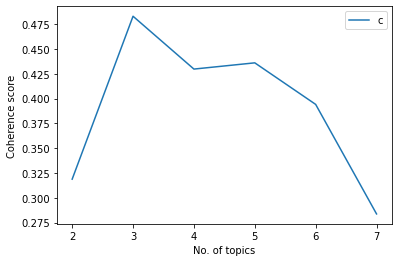

In [31]:
display_coherence_values(cyberpunk_pos_id2word, cyberpunk_pos_corpus, cyberpunk_pos_processed_text, start=2, limit=8, step=1)

### Negative

In [32]:
cyberpunk_neg_processed_text, cyberpunk_neg_id2word, cyberpunk_neg_corpus = build_bigrams_trigrams(0, cyberpunk_ml)

In [33]:
# build LDA model

cyberpunk_neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=cyberpunk_neg_corpus,
                                                          id2word=cyberpunk_neg_id2word,
                                                          num_topics=5, 
                                                          random_state=42,
                                                          update_every=1,
                                                          chunksize=100,
                                                          passes=10,
                                                          alpha='auto',
                                                          iterations=100,
                                                          per_word_topics=True)

In [34]:
display_dominant_topics(cyberpunk_neg_lda_model, cyberpunk_neg_corpus, cyberpunk_neg_processed_text, 15)

,Document_No,Dominant_Topic,Percentage_Contribution,Keywords,Text
0,0,4.0,0.7873,"game, not, bug, play, get, even, like, fix, ti...","[glitchy, crash, lot, literally, 80, 90, game,..."
1,1,3.0,0.4016,"fps, low, run, pc, spec, high, medium, perform...","[make, config, assign, 25gb, ram, 6gb_vram, 20..."
2,2,1.0,0.4065,"no, like, character, go, get, one, feel, only,...","[cyberpunk_2077, say, promise, trove, feature,..."
3,3,1.0,0.6289,"no, like, character, go, get, one, feel, only,...","[firstly, wanna, say, game, isnt, bad, actuall..."
4,4,4.0,0.4334,"game, not, bug, play, get, even, like, fix, ti...","[extremely, little, game, play, way, much, int..."
5,5,1.0,0.4532,"no, like, character, go, get, one, feel, only,...","[current, playtime, don't, think, recommend, g..."
6,6,4.0,0.5298,"game, not, bug, play, get, even, like, fix, ti...","[find, pretty, bore, game, relatively, quickly..."
7,7,4.0,0.6564,"game, not, bug, play, get, even, like, fix, ti...","[story, good, game, good, cant, recommend, get..."
8,8,4.0,0.6716,"game, not, bug, play, get, even, like, fix, ti...","[bug, iron, lack, feature, replayability, real..."
9,9,1.0,0.6044,"no, like, character, go, get, one, feel, only,...","[i've, played, 40, hour, far, yet, finish, sto..."


In [35]:
display_representative_docs(cyberpunk_neg_lda_model, cyberpunk_neg_corpus, cyberpunk_neg_processed_text)

,Topic_Num,Topic_Percentage_Contribution,Keywords,Representative Text
0,0.0,0.4837,"world, open, rpg, cyberpunk, feel, story, lack...","[like, electronic, art's, mirror's, edge, synd..."
1,1.0,0.7658,"no, like, character, go, get, one, feel, only,...","[bug, glitch, aside, lot, stuff, miss, dampens..."
2,2.0,0.5149,"ai, car, npc, drive, spawn, no, police, walk, ...","[list, feature, miss, quality, life, walk, tog..."
3,3.0,0.7527,"fps, low, run, pc, spec, high, medium, perform...","[sabse, bada, chootmarika, game, hai, madarcho..."
4,4.0,0.8830,"game, not, bug, play, get, even, like, fix, ti...","[say, game, overhyped, devs, not, deliver, pro..."


In [36]:
compute_perp_coherence(ldamodel=cyberpunk_neg_lda_model, 
                       dictionary=cyberpunk_neg_id2word,
                       corpus=cyberpunk_neg_corpus, 
                       texts=cyberpunk_neg_processed_text)

Perplexity: -7.4035
Coherence Score: 0.4740


In [37]:
# visualize the topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(cyberpunk_neg_lda_model, cyberpunk_neg_corpus, cyberpunk_neg_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.299814  0.077575       1        1  46.603721
1      0.240837 -0.032557       2        1  37.923801
0     -0.148920 -0.188407       3        1   6.539761
2     -0.166135 -0.187125       4        1   4.609752
3     -0.225596  0.330514       5        1   4.322965, topic_info=         Term          Freq         Total Category  logprob  loglift
7        game  37408.000000  37408.000000  Default  30.0000  30.0000
163       run   4148.000000   4148.000000  Default  29.0000  29.0000
199     world   4221.000000   4221.000000  Default  28.0000  28.0000
136        no   7576.000000   7576.000000  Default  27.0000  27.0000
138       npc   2713.000000   2713.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
209        50    271.514281    539.106146   Topic5  -5.0487   2.4553
406       set    324.360394   1218.041386   Topic5  -4.8709   1.8181
567      drop    252.533830    507.345458   Topic5  -5.1212   2.4436
1035      use    332.238327   2007.258884   Topic5  -4.8469   1.3426
932   graphic    335.930334   2174.745641   Topic5  -4.8358   1.2735

[303 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
847       1  0.957216     10
847       2  0.042759     10
1224      5  0.996422  1080p
2146      5  0.996159  1440p
539       1  0.276808     30
...     ...       ...    ...
199       4  0.076038  world
200       1  0.999502  worth
18        1  0.843137  would
18        2  0.156618  would
452       1  0.999700   year

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

**Topic Interpretation**

- **1**: overall negative sentiments about the game (crash, update, fix)
- **2**: generic gameplay terms (mission, combat, npc), story-related terms (dialogue, quest, choice)
- **3**: comparisons with other open world games of somewhat similar genres (deus ex, gta),
- **4**: glitches with the game (randomly, disappear, teleport), ai issues
- **5**: technical issues, fps, resolution, driver, controller, performance

Coherence value for 2 topics: 0.3641
Coherence value for 3 topics: 0.3425
Coherence value for 4 topics: 0.3402
Coherence value for 5 topics: 0.4740
Coherence value for 6 topics: 0.3720
Coherence value for 7 topics: 0.4651


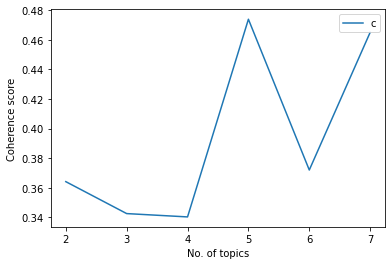

In [38]:
display_coherence_values(cyberpunk_neg_id2word, cyberpunk_neg_corpus, cyberpunk_neg_processed_text, start=2, limit=8, step=1)

## Fall Guys

### Positive

In [39]:
fallguys_pos_processed_text, fallguys_pos_id2word, fallguys_pos_corpus = build_bigrams_trigrams(1, fallguys_ml)

In [40]:
# build LDA model

fallguys_pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=fallguys_pos_corpus,
                                                          id2word=fallguys_pos_id2word,
                                                          num_topics=4, 
                                                          random_state=42,
                                                          update_every=1,
                                                          chunksize=100,
                                                          passes=10,
                                                          alpha='auto',
                                                          iterations=100,
                                                          per_word_topics=True)

In [41]:
display_dominant_topics(fallguys_pos_lda_model, fallguys_pos_corpus, fallguys_pos_processed_text, 15)

,Document_No,Dominant_Topic,Percentage_Contribution,Keywords,Text
0,0,3.0,0.4926,"game, fun, play, get, server, time, friend, li...","[thought, fall, guy, ultimate_knockout, i've, ..."
1,1,3.0,0.4641,"game, fun, play, get, server, time, friend, li...","[no, battlepass, no, overwhelm, progression_sy..."
2,2,3.0,0.5076,"game, fun, play, get, server, time, friend, li...","[much, fun, especially, friend, even, though, ..."
3,3,3.0,0.4645,"game, fun, play, get, server, time, friend, li...","[game, chaotic, fun, recommend, people, play, ..."
4,4,3.0,0.5861,"game, fun, play, get, server, time, friend, li...","[nice, casual, multiplayer, game, relax, fun, ..."
5,5,3.0,0.4943,"game, fun, play, get, server, time, friend, li...","[amaze, fun, never, end, cute, art, stile, loo..."
6,6,3.0,0.5102,"game, fun, play, get, server, time, friend, li...","[good, game, play, friend, would, recomend, bu..."
7,7,3.0,0.4785,"game, fun, play, get, server, time, friend, li...","[really, fun, game, only, thing, miss, private..."
8,8,3.0,0.6096,"game, fun, play, get, server, time, friend, li...","[game, great, especially, friend, know, game, ..."
9,9,3.0,0.4795,"game, fun, play, get, server, time, friend, li...","[try, hold_shift, get, light, rail, jp, cn, 6,..."


In [42]:
display_representative_docs(fallguys_pos_lda_model, fallguys_pos_corpus, fallguys_pos_processed_text)

,Topic_Num,Topic_Percentage_Contribution,Keywords,Representative Text
0,0.0,0.5735,"fall, 10, guy, launch, player, win, round, go,...","[fall, guy, im, fall, guy, fall, guy, fall, gu..."
1,1.0,0.5767,"takeshi's_castle, show, 60, ever, yes, probabl...","[rainbowpls_pa, yeta, yu, rainbowpls_pa, aye, ..."
2,2.0,0.6752,"more, team, only, see, map, not, need, party, ...","[graphic_forget_reality_beautiful, good, decen..."
3,3.0,0.7416,"game, fun, play, get, server, time, friend, li...","[really, recommend, try, game, buying, im, lov..."


In [43]:
compute_perp_coherence(ldamodel=fallguys_pos_lda_model, 
                       dictionary=fallguys_pos_id2word,
                       corpus=fallguys_pos_corpus, 
                       texts=fallguys_pos_processed_text)

Perplexity: -6.9788
Coherence Score: 0.4093


In [44]:
# visualize the topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(fallguys_pos_lda_model, fallguys_pos_corpus, fallguys_pos_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.241458 -0.064008       1        1  46.673155
2     -0.172900  0.242454       2        1  27.990282
0      0.068529 -0.317985       3        1  18.124747
1      0.345829  0.139539       4        1   7.211816, topic_info=         Term          Freq         Total Category  logprob  loglift
53       game  42633.000000  42633.000000  Default  30.0000  30.0000
51        fun  16605.000000  16605.000000  Default  29.0000  29.0000
116      play  10321.000000  10321.000000  Default  28.0000  28.0000
93       more   5916.000000   5916.000000  Default  27.0000  27.0000
46       fall   4357.000000   4357.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1961    human    251.964225    252.669503   Topic4  -5.2171   2.6267
269   believe    248.244149    248.960917   Topic4  -5.2320   2.6266
1314  imagine    244.232591    244.938006   Topic4  -5.2483   2.6266
1764   winner    237.278105    237.989259   Topic4  -5.2772   2.6265
367      show    979.075718    990.260116   Topic4  -3.8598   2.6181

[187 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.999776      1
403       3  0.999793     10
233       2  0.999428      2
1797      4  0.997403   2020
171       2  0.999339      3
...     ...       ...    ...
621       1  0.999818  worth
169       1  0.994112  would
169       2  0.005862  would
1690      4  0.997912   year
788       4  0.999570    yes

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

**Topic Interpretation**

- **1**: overall positive sentiments about the game
- **2**: suggestions to developers for improvements (add, new, level, release, mode)
- **3**: gameplay terms (physics, grab, crown, currency)
- **4**: comparisons with similar popular TV shows/games (takeshi's castle, MXC, wipeout, mario party), nature of the game (indie, addictive)

Coherence value for 2 topics: 0.3573
Coherence value for 3 topics: 0.4030
Coherence value for 4 topics: 0.4093
Coherence value for 5 topics: 0.3585
Coherence value for 6 topics: 0.3948
Coherence value for 7 topics: 0.3550


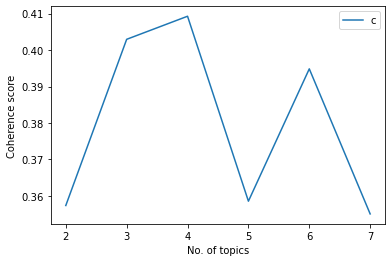

In [45]:
display_coherence_values(fallguys_pos_id2word, fallguys_pos_corpus, fallguys_pos_processed_text, start=2, limit=8, step=1)

### Negative

In [46]:
fallguys_neg_processed_text, fallguys_neg_id2word, fallguys_neg_corpus = build_bigrams_trigrams(0, fallguys_ml)

In [47]:
# build LDA model

fallguys_neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=fallguys_neg_corpus,
                                                          id2word=fallguys_neg_id2word,
                                                          num_topics=5, 
                                                          random_state=42,
                                                          update_every=1,
                                                          chunksize=100,
                                                          passes=10,
                                                          alpha='auto',
                                                          iterations=100,
                                                          per_word_topics=True)

In [48]:
display_dominant_topics(fallguys_neg_lda_model, fallguys_neg_corpus, fallguys_neg_processed_text, 15)

,Document_No,Dominant_Topic,Percentage_Contribution,Keywords,Text
0,0,4.0,0.5772,"game, get, not, play, fun, server, time, no, m...","[lazy, devs, take, away, steam, name, prevent,..."
1,1,4.0,0.7710,"game, get, not, play, fun, server, time, no, m...","[game, bad, literally, new, game, hard, never,..."
2,2,4.0,0.7435,"game, get, not, play, fun, server, time, no, m...","[game, suck, dead, playerbase, only, 10k, most..."
3,3,4.0,0.6749,"game, get, not, play, fun, server, time, no, m...","[steam, name, censor, game, keep, freeze, rand..."
4,4,4.0,0.7185,"game, get, not, play, fun, server, time, no, m...","[fun, first, hour, there's, not, much, more, s..."
5,5,4.0,0.6748,"game, get, not, play, fun, server, time, no, m...","[okay, play, couple, hour, quit, forever, buy,..."
6,6,4.0,0.7642,"game, get, not, play, fun, server, time, no, m...","[game, move, way, slow, take, forever, find, g..."
7,7,4.0,0.6869,"game, get, not, play, fun, server, time, no, m...","[fun, little, take, way, long, add, new, level..."
8,8,4.0,0.7045,"game, get, not, play, fun, server, time, no, m...","[personally, like, game, get, boring, time, ge..."
9,9,4.0,0.7156,"game, get, not, play, fun, server, time, no, m...","[played, first, season, kept, think, man, game..."


In [49]:
display_representative_docs(fallguys_neg_lda_model, fallguys_neg_corpus, fallguys_neg_processed_text)

,Topic_Num,Topic_Percentage_Contribution,Keywords,Representative Text
0,0.0,0.5828,"review, launch, use, name, remove, developer, ...","[arreglen, lo, servidores, la, calcada, concha..."
1,2.0,0.4238,"fall, grab, guy, tail, race, last, player, sea...","[fall, ball, fall, ball, fall, ball, fall, bal..."
2,4.0,0.8624,"game, get, not, play, fun, server, time, no, m...","[game, fun, work, disconnect, every, game, not..."


In [50]:
compute_perp_coherence(ldamodel=fallguys_neg_lda_model, 
                       dictionary=fallguys_neg_id2word,
                       corpus=fallguys_neg_corpus, 
                       texts=fallguys_neg_processed_text)

Perplexity: -6.9974
Coherence Score: 0.3869


In [51]:
# visualize the topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(fallguys_neg_lda_model, fallguys_neg_corpus, fallguys_neg_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.345429  0.150960       1        1  65.198187
1     -0.134827 -0.296603       2        1  11.952289
3      0.102705  0.155820       3        1   8.987432
2      0.182831  0.156907       4        1   8.124541
0      0.194721 -0.167084       5        1   5.737552, topic_info=             Term          Freq         Total Category  logprob  loglift
36           game  24338.000000  24338.000000  Default  30.0000  30.0000
242          team   4066.000000   4066.000000  Default  29.0000  29.0000
268        player   2611.000000   2611.000000  Default  28.0000  28.0000
855        review   1216.000000   1216.000000  Default  27.0000  27.0000
156          fall   1360.000000   1360.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
517   mario_party    109.517599    110.149597   Topic5  -5.2952   2.8524
1453    developer    406.117360    408.640647   Topic5  -3.9846   2.8519
842           use    498.463471    506.509619   Topic5  -3.7797   2.8421
111        launch    693.636218    899.585279   Topic5  -3.4493   2.5982
473        number    220.021815    267.101699   Topic5  -4.5975   2.6642

[216 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
215       1  0.999230      1
138       1  0.999263      2
74        2  0.999110     20
140       1  0.999362      3
430       4  0.996002     50
...     ...       ...    ...
501       2  0.999579  worth
91        1  0.966608  would
91        2  0.033314  would
880       5  0.997146  write
502       4  0.996891    yet

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

**Topic Interpretation**

- **1**: overall negative sentiments about the game (bad, issue)
- **2**: complaints specific to level design (variety of game modes, boring, lack of content/stages) and cosmetics
- **3**: complaints specific to gameplay mechanics (buggy, physics, rng, jump)
- **4**: generic gameplay terms (eliminate, grab, skin, currency)
- **5**: monetization elements (dlc, microtransactions), suggestions for developers (anti-cheat, report, ban)


Coherence value for 2 topics: 0.3756
Coherence value for 3 topics: 0.3798
Coherence value for 4 topics: 0.3629
Coherence value for 5 topics: 0.3869
Coherence value for 6 topics: 0.3149
Coherence value for 7 topics: 0.2820


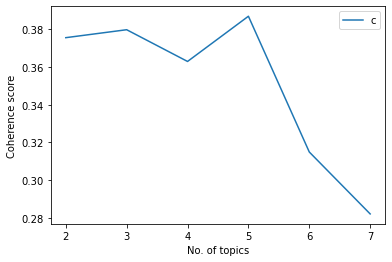

In [52]:
display_coherence_values(fallguys_neg_id2word, fallguys_neg_corpus, fallguys_neg_processed_text, start=2, limit=8, step=1)

## Evaluation of Topic Modelling

![Results for Topic Modelling](./results/lda.png)

The topic coherence reflects the score of a topic by measuring the degree of semantic similarity between high scoring words in the topic itself. The optimal number of topics is thus when the overall topic coherence is highest.

The highest topic coherences (highlighted in green) for each dataset are a little low, ranging between **0.38** to **0.48**. This suggests that the topics may not be particularly well defined in our datasets as we would like. Nonetheless, based on our interpretation, we can still see the semblance of some dominant themes in the corpus. From the pyLDAvis output, we also see that the topic bubbles are fairly large and non-overlapping in most cases, and also span different quadrants instead of being clustered together in the same quadrant. This is indicative that the topic model performed adequately well.

## Extract Topics for Classification

Cyberpunk's reviews (both positive and negative) obtained the highest topic coherence score amongst the 3 games after performing LDA. We will extract the dominant topics for the various texts and attempt to perform multi-class classification of incoming reviews to predict their dominant topic.

In [53]:
cyberpunk_pos_df = format_topics_sentences(cyberpunk_pos_lda_model, cyberpunk_pos_corpus, cyberpunk_pos_processed_text)

In [54]:
cyberpunk_pos_topic_df = pd.concat([cyberpunk_ml[cyberpunk_ml['label'] == 1].reset_index(), cyberpunk_pos_df], axis=1)

In [55]:
cyberpunk_pos_topic_df.head()

,index,Unnamed: 0,recommendationid,author,language,review,timestamp_created,timestamp_updated,label,votes_up,...,clean_text,clean_text_punct,review_length,lemmed_text,lemmed_review_length,spam_detected,Dominant_Topic,Percentage_Contribution,Topic_Keywords,0
0,1,5,82531637,"{'steamid': '76561198151364624', 'num_games_ow...",english,"Despite what people say, game's fucking amazin...",2020-12-17,2020-12-17,1,0,...,despite what people say game's fucking amazing...,Despite what people say game's fucking amazing...,22,despite people say game's fuck amaze lot fun p...,14,0,0.0,0.9320,"game, bug, play, not, get, far, story, good, g...","[despite, people, say, game's, fuck, amaze, lo..."
1,2,6,82531621,"{'steamid': '76561197970539101', 'num_games_ow...",english,The game isn't without it's bugs but they are ...,2020-12-17,2020-12-17,1,0,...,the game isn't without it's bugs but they are ...,The game isn't without it's bugs but they are ...,32,game isn't without bug relatively easy ignore ...,15,0,0.0,0.9185,"game, bug, play, not, get, far, story, good, g...","[game, isn't, without, bug, relatively, easy, ..."
2,3,7,82531619,"{'steamid': '76561198339128191', 'num_games_ow...",english,"Very atmospheric, great game play, voice actin...",2020-12-17,2020-12-17,1,0,...,very atmospheric great game play voice acting ...,Very atmospheric great game play voice acting ...,119,atmospheric great game play voice act graphic ...,66,0,0.0,0.5418,"game, bug, play, not, get, far, story, good, g...","[atmospheric, great, game, play, voice_act, gr..."
3,4,8,82531600,"{'steamid': '76561198037914552', 'num_games_ow...",english,I am really unsure of why I am so drawn into t...,2020-12-17,2020-12-17,1,0,...,i am really unsure of why i am so drawn into t...,I am really unsure of why I am so drawn into t...,212,really unsure drawn game look non technical si...,112,0,1.0,0.5614,"feel, character, like, drive, not, city, go, m...","[really, unsure, drawn, game, look, non, techn..."
4,5,9,82531594,"{'steamid': '76561198157915459', 'num_games_ow...",english,"Really good game. Perfect storyline, great cha...",2020-12-17,2020-12-17,1,0,...,really good game perfect storyline great chara...,Really good game. Perfect storyline great char...,90,really good game perfect storyline great chara...,52,0,0.0,0.8718,"game, bug, play, not, get, far, story, good, g...","[really, good, game, perfect, storyline, great..."


In [56]:
cyberpunk_neg_df = format_topics_sentences(cyberpunk_neg_lda_model, cyberpunk_neg_corpus, cyberpunk_neg_processed_text)

In [57]:
cyberpunk_neg_topic_df = pd.concat([cyberpunk_ml[cyberpunk_ml['label'] == 0].reset_index(), cyberpunk_neg_df], axis=1)

In [58]:
cyberpunk_neg_topic_df.head()

,index,Unnamed: 0,recommendationid,author,language,review,timestamp_created,timestamp_updated,label,votes_up,...,clean_text,clean_text_punct,review_length,lemmed_text,lemmed_review_length,spam_detected,Dominant_Topic,Percentage_Contribution,Topic_Keywords,0
0,0,0,82531665,"{'steamid': '76561198955470036', 'num_games_ow...",english,Glitchy and crashes a lot. Literally 80%-90% o...,2020-12-17,2020-12-17,0,0,...,glitchy and crashes a lot literally 80 90 of t...,Glitchy and crashes a lot. Literally 80 90 of ...,40,glitchy crash lot literally 80 90 game buy ste...,21,0,4.0,0.7873,"game, not, bug, play, get, even, like, fix, ti...","[glitchy, crash, lot, literally, 80, 90, game,..."
1,19,25,82531443,"{'steamid': '76561197965639279', 'num_games_ow...",english,I now have made config where i assigned 25GB R...,2020-12-17,2020-12-17,0,0,...,i now have made config where i assigned 25gb r...,I now have made config where i assigned 25GB R...,69,make config assign 25gb ram 6gb vram 20gb virt...,36,0,3.0,0.4016,"fps, low, run, pc, spec, high, medium, perform...","[make, config, assign, 25gb, ram, 6gb_vram, 20..."
2,49,66,82531120,"{'steamid': '76561198031887117', 'num_games_ow...",english,"Cyberpunk 2077, what is there to say. We were ...",2020-12-17,2020-12-17,0,0,...,cyberpunk 2077 what is there to say we were pr...,Cyberpunk 2077 what is there to say. We were p...,326,cyberpunk 2077 say promise trove feature pitch...,199,0,1.0,0.4065,"no, like, character, go, get, one, feel, only,...","[cyberpunk_2077, say, promise, trove, feature,..."
3,52,73,82531063,"{'steamid': '76561198032616291', 'num_games_ow...",english,"firstly i wanna say this game isnt bad, i actu...",2020-12-17,2020-12-17,0,8,...,firstly i wanna say this game isnt bad i actua...,firstly i wanna say this game isnt bad i actua...,908,firstly wanna say game isnt bad actually enjoy...,474,0,1.0,0.6289,"no, like, character, go, get, one, feel, only,...","[firstly, wanna, say, game, isnt, bad, actuall..."
4,53,77,82531028,"{'steamid': '76561198017900499', 'num_games_ow...",english,There is extremely little game play and way to...,2020-12-17,2020-12-17,0,6,...,there is extremely little game play and way to...,There is extremely little game play and way to...,21,extremely little game play way much interactio...,12,0,4.0,0.4334,"game, not, bug, play, get, even, like, fix, ti...","[extremely, little, game, play, way, much, int..."


In [59]:
# output to csv files

cyberpunk_pos_topic_df.to_csv('datasets/cyberpunkpostopic.csv', index=False)
cyberpunk_neg_topic_df.to_csv('datasets/cyberpunknegtopic.csv', index=False)

# Topic Classification

Assuming that the above corpus of text can in fact be segregated into well-defined topics that are coherent and make sense, we can then perform machine learning methods to classify reviews into their dominant topics.

This is beneficial in helping the developers detect if there are certain aspects of the game that require closer and immediate attention to be fixed/patched - e.g. if there is a sudden influx of negative reviews regarding glitches, or if the game is suddenly unable to run smoothly after a particular game update had been released. 

Similarly, the classification can also be used to gauge the players' reception to a particular game feature that was recently launched - for instance, if the topic appears often in positive reviews, this also serves as positive reinforcement to the developers that they are doing a good job in continually exciting their players.

Here, we will fit simple, untuned classification models to explore how machine learning methods can be employed for this purpose.

In [60]:
# create dictionary of dataframes and names

dfs_topic = {"Cyberpunk Positive Reviews": cyberpunk_pos_topic_df, 
             "Cyberpunk Negative Reviews": cyberpunk_neg_topic_df, 
            }

In [61]:
# drop unwanted columns

for df in dfs_topic.values():
    df.drop(columns=['index', 'Unnamed: 0'], inplace=True)

In [62]:
# rename columns in dataframe

for df in dfs_topic.values():
    df.rename(columns={'Dominant_Topic': 'dominant_topic',
                       'Percentage_Contribution': 'percent_contribution',
                       'Topic_Keywords': 'topic_keywords',
                       '0': 'processed_lda_text',
                      },
              inplace=True
             )

In [63]:
# convert label column from float to int

for df in dfs_topic.values():
    df['dominant_topic'] = df['dominant_topic'].astype(int)

## Positive Reviews

In [64]:
cyberpunk_pos_topic_df['dominant_topic'].value_counts(normalize=True)

0    0.932604
1    0.055516
2    0.011880
Name: dominant_topic, dtype: float64

There are only 1% of reviews that have been classified as being predominantly topic 3.

In [65]:
X_cyberpunk_pos = cyberpunk_pos_topic_df['lemmed_text']
y_cyberpunk_pos = cyberpunk_pos_topic_df['dominant_topic']

In [66]:
# create training and test sets

X_cyberpunk_pos_train, X_cyberpunk_pos_test, y_cyberpunk_pos_train, y_cyberpunk_pos_test = train_test_split(X_cyberpunk_pos,
                                                                                                            y_cyberpunk_pos,
                                                                                                            test_size=0.25,
                                                                                                            stratify=y_cyberpunk_pos,
                                                                                                            random_state=42)

### Logistic Regression

In [67]:
# set up pipeline for LogisticRegression

pipe_cyberpunk_pos_lr = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('lr', SGDClassifier(loss='log', penalty='l2'))
])

In [68]:
pipe_cyberpunk_pos_lr.fit(X_cyberpunk_pos_train, y_cyberpunk_pos_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('lr', SGDClassifier(loss='log'))])

In [69]:
def multiclass_scores(model, model_name, X_train, X_test, y_train, y_test):
    """
    Prints the relevant metrics for multiclass classification and plots the confusion matrix.
    """
    print('------------')
    print(f'Metrics for {model_name}')
    print('------------')
    print(f'Accuracy score on train data ------------: {model.score(X_train, y_train):.4f}')
    print(f'Accuracy score on test data -------------: {model.score(X_test, y_test):.4f}')
    print(f'Balanced accuracy score on test data ----: {balanced_accuracy_score(y_test, model.predict(X_test)):.4f}')
    
    if model_name != 'Support Vector Classifier':        
        print(f'ROC-AUC score on test data --------------: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr"):.4f}')
    
    plot_confusion_matrix(model, X_test, y_test);

------------
Metrics for Logistic Regression
------------
Accuracy score on train data ------------: 0.9092
Accuracy score on test data -------------: 0.8965
Balanced accuracy score on test data ----: 0.9382
ROC-AUC score on test data --------------: 0.9871


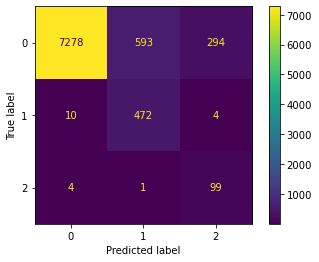

In [70]:
multiclass_scores(pipe_cyberpunk_pos_lr, 
                  'Logistic Regression',
                  X_cyberpunk_pos_train, 
                  X_cyberpunk_pos_test, 
                  y_cyberpunk_pos_train, 
                  y_cyberpunk_pos_test
                 )

### Naive Bayes Classifier

In [71]:
# set up pipeline for MultinomialNB

pipe_cyberpunk_pos_nb = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('nb', MultinomialNB())
])

In [72]:
pipe_cyberpunk_pos_nb.fit(X_cyberpunk_pos_train, y_cyberpunk_pos_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('nb', MultinomialNB())])

------------
Metrics for Naive Bayes
------------
Accuracy score on train data ------------: 0.8818
Accuracy score on test data -------------: 0.8600
Balanced accuracy score on test data ----: 0.9327
ROC-AUC score on test data --------------: 0.9837


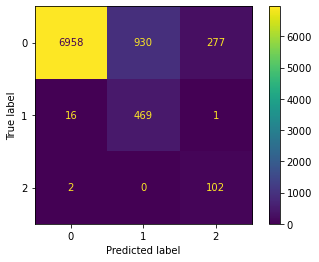

In [73]:
multiclass_scores(pipe_cyberpunk_pos_nb,
                  'Naive Bayes',
                  X_cyberpunk_pos_train, 
                  X_cyberpunk_pos_test, 
                  y_cyberpunk_pos_train, 
                  y_cyberpunk_pos_test
                 )

### Random Forest Classifier

In [74]:
# set up pipeline for RandomForestClassifier

pipe_cyberpunk_pos_rf = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('rf', RandomForestClassifier(n_estimators=200, 
                                                      max_depth=5, 
                                                      min_samples_split=3,
                                                      random_state=42))
])

In [75]:
pipe_cyberpunk_pos_rf.fit(X_cyberpunk_pos_train, y_cyberpunk_pos_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_split=3,
                                        n_estimators=200, random_state=42))])

------------
Metrics for Random Forest
------------
Accuracy score on train data ------------: 0.8093
Accuracy score on test data -------------: 0.8010
Balanced accuracy score on test data ----: 0.8021
ROC-AUC score on test data --------------: 0.9084


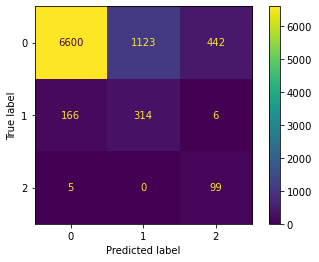

In [76]:
multiclass_scores(pipe_cyberpunk_pos_rf, 
                  'Random Forest',
                  X_cyberpunk_pos_train, 
                  X_cyberpunk_pos_test, 
                  y_cyberpunk_pos_train, 
                  y_cyberpunk_pos_test
                 )

### Support Vector Classifier

In [77]:
# set up pipeline for RandomForestClassifier

pipe_cyberpunk_pos_svc = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('svc', SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001))
])

In [78]:
pipe_cyberpunk_pos_svc.fit(X_cyberpunk_pos_train, y_cyberpunk_pos_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('svc', SGDClassifier())])

------------
Metrics for Support Vector Classifier
------------
Accuracy score on train data ------------: 0.9548
Accuracy score on test data -------------: 0.9397
Balanced accuracy score on test data ----: 0.9092


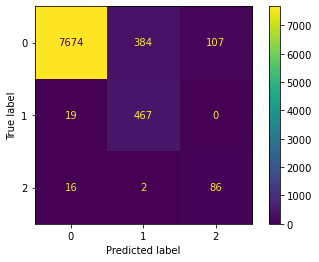

In [79]:
multiclass_scores(pipe_cyberpunk_pos_svc,
                  'Support Vector Classifier',
                  X_cyberpunk_pos_train, 
                  X_cyberpunk_pos_test, 
                  y_cyberpunk_pos_train, 
                  y_cyberpunk_pos_test
                 )

## Negative Reviews

In [80]:
cyberpunk_neg_topic_df['dominant_topic'].value_counts(normalize=True)

4    0.837896
1    0.159319
3    0.001910
2    0.000716
0    0.000159
Name: dominant_topic, dtype: float64

Although it was shown from our earlier LDA that 5 topics gave the highest coherence score, there are far too few samples for topics 0, 2 and 3 to provide any meaningful analysis. We will drop these rows from our dataset and re-encode the remaining samples.

In [81]:
# drop those rows with topics 0, 2, 3

cyberpunk_neg_topic_df.drop(cyberpunk_neg_topic_df[cyberpunk_neg_topic_df['dominant_topic'].isin([0, 2, 3])].index,
                            inplace=True)

In [82]:
# reencode topic 4 to topic 0

cyberpunk_neg_topic_df.loc[cyberpunk_neg_topic_df['dominant_topic'] == 4, 'dominant_topic'] = 0

In [83]:
cyberpunk_neg_topic_df['dominant_topic'].value_counts(normalize=True)

0    0.840236
1    0.159764
Name: dominant_topic, dtype: float64

In [84]:
X_cyberpunk_neg = cyberpunk_neg_topic_df['lemmed_text']
y_cyberpunk_neg = cyberpunk_neg_topic_df['dominant_topic']

In [85]:
# create training and test sets

X_cyberpunk_neg_train, X_cyberpunk_neg_test, y_cyberpunk_neg_train, y_cyberpunk_neg_test = train_test_split(X_cyberpunk_neg,
                                                                                                            y_cyberpunk_neg,
                                                                                                            test_size=0.25,
                                                                                                            stratify=y_cyberpunk_neg,
                                                                                                            random_state=42)

### Logistic Regression

In [86]:
# set up pipeline for LogisticRegression

pipe_cyberpunk_neg_lr = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('lr', SGDClassifier(loss='log', penalty='l2'))
])

In [87]:
pipe_cyberpunk_neg_lr.fit(X_cyberpunk_neg_train, y_cyberpunk_neg_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('lr', SGDClassifier(loss='log'))])

In [88]:
def binaryclass_scores(model, model_name, X_train, X_test, y_train, y_test):
    """
    Prints the relevant metrics for binary classification and plots the confusion matrix.
    """
    print('------------')
    print(f'Metrics for {model_name}')
    print('------------')
    print(f'Accuracy score on train data ------------: {model.score(X_train, y_train):.4f}')
    print(f'Accuracy score on test data -------------: {model.score(X_test, y_test):.4f}')
   
    if model_name != 'Support Vector Classifier':        
        print(f'ROC-AUC score on test data --------------: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}')
    
    plot_confusion_matrix(model, X_test, y_test);

------------
Metrics for Logistic Regression
------------
Accuracy score on train data ------------: 0.9606
Accuracy score on test data -------------: 0.9349
ROC-AUC score on test data --------------: 0.9853


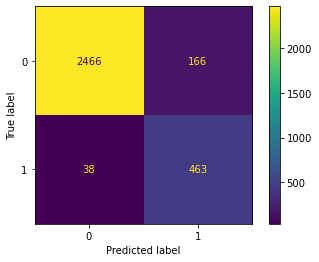

In [89]:
binaryclass_scores(pipe_cyberpunk_neg_lr, 
                  'Logistic Regression',
                  X_cyberpunk_neg_train, 
                  X_cyberpunk_neg_test, 
                  y_cyberpunk_neg_train, 
                  y_cyberpunk_neg_test
                 )

### Naive Bayes Classifier

In [90]:
# set up pipeline for MultinomialNB

pipe_cyberpunk_neg_nb = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('nb', MultinomialNB())
])

In [91]:
pipe_cyberpunk_neg_nb.fit(X_cyberpunk_neg_train, y_cyberpunk_neg_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('nb', MultinomialNB())])

------------
Metrics for Naive Bayes
------------
Accuracy score on train data ------------: 0.8460
Accuracy score on test data -------------: 0.8142
ROC-AUC score on test data --------------: 0.9761


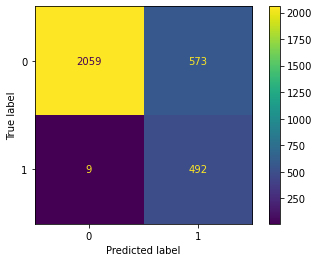

In [92]:
binaryclass_scores(pipe_cyberpunk_neg_nb,
                  'Naive Bayes',
                  X_cyberpunk_neg_train, 
                  X_cyberpunk_neg_test, 
                  y_cyberpunk_neg_train, 
                  y_cyberpunk_neg_test
                 )

### Random Forest Classifier

In [93]:
# set up pipeline for RandomForestClassifier

pipe_cyberpunk_neg_rf = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('rf', RandomForestClassifier(n_estimators=200, 
                                                      max_depth=5, 
                                                      min_samples_split=3,
                                                      random_state=42))
])

In [94]:
pipe_cyberpunk_neg_rf.fit(X_cyberpunk_neg_train, y_cyberpunk_neg_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_split=3,
                                        n_estimators=200, random_state=42))])

------------
Metrics for Random Forest
------------
Accuracy score on train data ------------: 0.8828
Accuracy score on test data -------------: 0.8758
ROC-AUC score on test data --------------: 0.9149


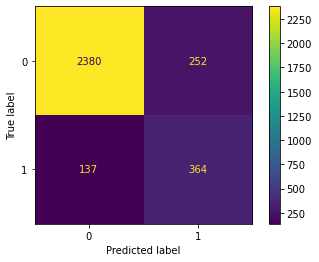

In [95]:
binaryclass_scores(pipe_cyberpunk_neg_rf, 
                  'Random Forest',
                  X_cyberpunk_neg_train, 
                  X_cyberpunk_neg_test, 
                  y_cyberpunk_neg_train, 
                  y_cyberpunk_neg_test
                 )

### Support Vector Classifier

In [96]:
# set up pipeline for RandomForestClassifier

pipe_cyberpunk_neg_svc = Pipeline([
                        ('tvec', TfidfVectorizer(analyzer = 'word',
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 )),
                        ('oversampler', RandomOverSampler(random_state=42)),
                        ('undersampler', RandomUnderSampler(random_state=42)),
                        ('svc', SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001))
])

In [97]:
pipe_cyberpunk_neg_svc.fit(X_cyberpunk_neg_train, y_cyberpunk_neg_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('svc', SGDClassifier())])

------------
Metrics for Support Vector Classifier
------------
Accuracy score on train data ------------: 0.9872
Accuracy score on test data -------------: 0.9486


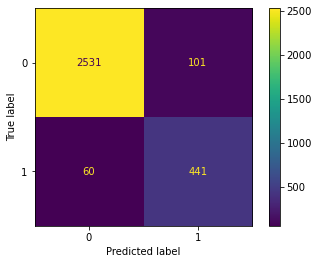

In [98]:
binaryclass_scores(pipe_cyberpunk_neg_svc,
                  'Support Vector Classifier',
                  X_cyberpunk_neg_train, 
                  X_cyberpunk_neg_test, 
                  y_cyberpunk_neg_train, 
                  y_cyberpunk_neg_test
                 )

## Model Evaluation

The results of the topic classification are shown as follows:

![Results for Topic Classification](./results/topic_classification.png)

Given the difficulty of extracting the various topics/classes cleanly, the scores obtained may not be representative of a good topic classification model. Nonetheless, the above analysis serves as a proof of concept that classification can be done.

Several limitations of performing this classification are as follows:
    
- Assumes that the topics make sense in the first place (there must be some logical interpretation as to various topics and their representative words)
- Needs to have a adequate distribution of each topic in the dataset
- Reviews are usually not cleanly segregated and do not only have one main topic - a single review often contains multiple topics with equal emphasis on each.
    - Multi-label classification can be carried out as future work
- Highly dependent on the nature of the language and how the reviews were written - properly formatted text will provide better results. Spam posts are hard to detect and may often skew the results - hence moderation of the social media platform is important
- If a new gameplay feature is added, it may take some time for sufficient reviews to surface before it appears as one of the topics



# Recommendations

We have performed sentiment analysis and topic modelling - how then can the publisher work with game companies to make use of the model to make data-driven decisions, and translate these efforts into increasing sales revenue and reducing gamer churn?

Although game platforms such as Steam allow users to directly recommend or not recommend a particular game (and hence generate a corresponding score), there exist a plethora of other online platforms where gamers/reviewers routinely post their thoughts and opinions on games, including the following:
- Video game review sites (Kotaku, Destruictoid, Metacritic)
- YouTube
- Facebook
- Twitter
- reddit
    - Platform specific subreddits e.g. r/pcgaming, r/ps4
    - General gaming subreddits e.g. r/gaming
    - Game specific subreddits e.g. r/FallGuysGame, r/cyberpunkgame

Comments on these platforms are typically **unlabeled**, and it would take a great deal of human effort to manually trawl through and tag these comments to capture their sentiment.

---

Thus, to aid the developers/publisher in better understanding overall user sentiment towards their games, we recommend the following approach:

- Scrape relevant comments/reviews from aforementioned online platforms

- For a *fast analysis*, we can consider employing **lexicon-based methods** to generate the overall polarity score of each review, to provide a quick overview for game developers on its sentiment
    - The upside of this is that no prior training of models is required
    - However, may not capture gaming terms that are specific to the game itself
    
    
- For a *deeper analysis*, **machine learning techniques** can be used to gain more insight into the top terms that reflect the overall sentiment, and typically results in better accuracy in predicting the overall sentiment of the comment/review
    - We can use the model to predict sentiments of games with **roughly similar genres**
        - Video game sentiments usually vary widely from game to game as gamers have different considerations depending on the genre, platform the game was launched on, etc. There may be a need to train the model on games of a similar genre to obtain more accurate predictions
        - While the top positive predictive features for our 3 games were somewhat similar, the negative predictive features revealed some differences (e.g. buggy vs. repetitive)
    - Developers/publishers can use the model to predict the sentiment of user comments on popular social media platforms and monitor the number of positive/negative reviews after an update has been rolled out. For instance,
        - If there is a large influx of reviews with 'refund', 'money' (given these were some of the top predictors of negative reviews) after a microtransaction pack is introduced - it is a signal that the company needs to quickly get things together and address some of these concerns, before players start to churn
        - On the other hand, if a new feature that is introduced (e.g. a new co-op mode) is highly popular and well-received, developers can explore incorporating more of such multiplayer modes in future games, or even variants of these modes in existing games as well
    
    
- Once a sizeable amount of reviews has been amassed, **LDA** can then be performed to sieve out more detail what gamers feel about the various positive and negative aspects of the game:
    - What features should the developers roll out next to entice new users into joining?
    - What kind of microtransactions are considered to be of fair value to gamers, such that they would consider purchasing them?
    - Whether there are bugs/glitches that were unintentionally introduced to the game after an update
    - To better understand comparisons to other popular rival games of the same genre (e.g. PUBG vs. Fortnite vs. Apex Legends) and the aspects that each game performs better at 
    
    
- **Classifying and tagging these comments by topic** would then complement and allow developers to prioritize which features to focus their efforts on

In the past, games were typically developed and launched one-off without any further updates from then on. However, given the ubiquity of online games in today's market, and how many of them are continually being polished and updated with new content, understanding user sentiment is of utmost importance to ensure that developers/publishers can continue to stand out amongst the competition and maintain their reputation as being a company that cares about their player base. 

---

**Limitations**

However, there are some considerations that developers would need to take into account when using the model for predicting sentiment:

- Models are not **fully generalizable across games** - suggests that demographics of gamers as well as the vocabulary used vary significantly across different genres
- May need to periodically train the model/corpus - since games update at a frequent pace today and the gamer demographic also changes with time
- Reviews often contain multiple sentiments all at once - some may be happy with certain aspects of the game but unhappy about others
- Unable to detect sarcasm, memes, well
- Should have a robust spam filter/detection system in place - these add a great deal of noise during training

# Conclusion

We have performed sentiment analysis via lexicon-based methods and machine-learning methods to classify game reviews from 3 different genres of games to be either positive or negative.

The best performing model, in terms of accuracy and interpretability across all three games was **Logistic Regression**, achieving the following accuracy scores and ROC-AUC scores:

|                          Game | ROC-AUC score | Accuracy |
|:-----------------------------:|:-------------:|:--------:|
| PlayerUnknown's Battlegrounds |        0.9267 |   0.8555 |
|                Cyberpunk 2077 |        0.9578 |   0.8955 |
|                     Fall Guys |        0.9364 |   0.8683 |

---

Notable predictors of overall sentiment for each of the games are as shown below:

|              Game             |                       Negative                      |                    Positive                    |
|:-----------------------------:|:---------------------------------------------------:|:----------------------------------------------:|
| PlayerUnknown's Battlegrounds | money, cheater, garbage, hacker, unplayable, refund |  best, great, good, fun, love, friend, addict  |
|         Cyberpunk 2077        | refund, boring, unplayable, crash, unfinished, mess | amaze, awesome, fantastic, perfect, definitely |
|           Fall Guys           | not worth, cheater, ruin, repetitive, hacker, trash |      fun, love, friend, bean, laugh, funny     |

---

Topic modelling was also performed for each game, using the topic coherence score to ascertain the optimal number of topics. The topics are interpreted to be as follows:

![Summary of LDA](./results/ldasummary.png)

---

Future work to improve our analysis includes the following:
- Obtain more data for analysis
    - Improve model's generalizability to more genres by training on a larger and varied corpus of words
- Incorporate better spam and meme detection (e.g. copypastas) for data cleaning
    - Reduce the amount of noise in our training dataset
- Dealing with typos, alternate/shortform spellings of words e.g. "sux", "gd"
- Improve topic classifier by tuning hyperparameters and trying multi-label classification
    - Previous analysis serves primarily as proof of concept

# References

**Game Reviews**
- https://www.gamesindustry.biz/articles/2015-02-09-what-drives-a-review-score

**Text Preprocessing**
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

**Sentiment Analysis**
- https://github.com/cjhutto/vaderSentiment#about-the-scoring
- https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
- https://towardsdatascience.com/nlp-sentiment-analysis-for-beginners-e7897f976897

**Topic Modelling - Gensim and LDA**
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

**Word Embeddings, Deep Learning**
- https://medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81
- https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
- https://machinelearningmastery.com/what-are-word-embeddings/
- https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space
- https://developers.google.com/machine-learning/crash-course/embeddings/obtaining-embeddings